In [134]:
import os
import glob
import random
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Compose

In [135]:
#Reading csv file for getting labels
img_labels = pd.read_csv('./data/trainLabels.csv')
img_labels

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
...,...,...
49995,49996,bird
49996,49997,frog
49997,49998,truck
49998,49999,automobile


In [136]:
class_to_num = dict(zip(list(img_labels['label'].unique()), range(len(img_labels['label'].unique()))))
num_to_class = {y: x for x, y in class_to_num.items()}
class_to_num

{'frog': 0,
 'truck': 1,
 'deer': 2,
 'automobile': 3,
 'bird': 4,
 'horse': 5,
 'ship': 6,
 'cat': 7,
 'dog': 8,
 'airplane': 9}

In [137]:
class get_images():
    def __init__(self, root, transform=None):
        self.images = list(Path(root).glob('*.png'))
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = self.images[idx]
        label = class_to_num[img_labels.iloc[idx]['label']]
        if self.transform:
            img = self.transform(Image.open(img))
        return img, label

In [138]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
    ])

In [139]:
img_path = './data/train/'
images_dataset = get_images(img_path, transform=transform)
print("normalized image: ", images_dataset[0])

normalized image:  (tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0.8431, -1.000

In [140]:
 # Denormalize the input from -1 to 1
def denorm(x):
     out = (x + 1) / 2
     return out.clamp(0, 1)

In [141]:
batch_size = 100
data_loader = DataLoader(images_dataset, batch_size, shuffle=True)

first batch
torch.Size([100, 3, 32, 32])
tensor([6, 3, 1, 3, 6, 8, 5, 8, 2, 9, 7, 9, 1, 5, 8, 5, 6, 1, 6, 2, 2, 4, 8, 1,
        8, 2, 8, 5, 8, 9, 4, 7, 5, 4, 7, 5, 2, 7, 0, 7, 6, 5, 1, 6, 6, 5, 9, 7,
        0, 6, 9, 0, 1, 1, 1, 5, 0, 5, 8, 7, 6, 1, 2, 3, 0, 0, 7, 8, 3, 2, 6, 3,
        5, 9, 7, 1, 8, 8, 6, 8, 4, 3, 3, 9, 4, 4, 6, 9, 1, 8, 0, 7, 3, 6, 5, 3,
        1, 1, 7, 0])


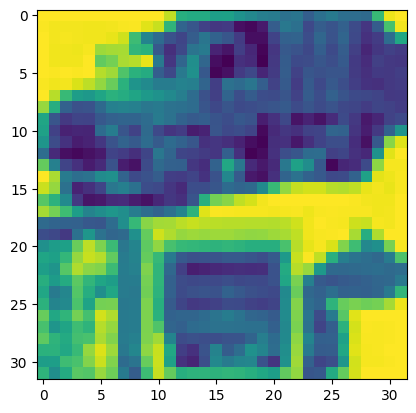

In [142]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0])
    print(label_batch)
    break

In [143]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [144]:
image_size = 3 * 32 * 32
hidden_size = 256

# Define the discriminator network
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [145]:
D.to(device)

Sequential(
  (0): Linear(in_features=3072, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [146]:
latent_size = 64

In [147]:
# Define the generator network
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

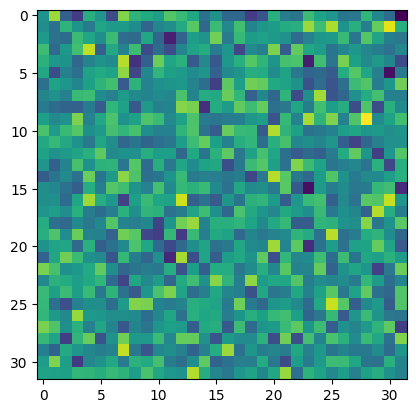

In [148]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 32, 32)).detach())
plt.imshow(gen_imgs[0])

In [149]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=3072, bias=True)
  (5): Tanh()
)

In [150]:
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr = 2e-3)
g_optimizer = optim.Adam(D.parameters(), lr = 2e-3)

In [151]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(data):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    
    # Loss for real images
    outputs = D(data)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs
    
    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs
    
    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
     # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score   

In [152]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)
                       
    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    
    return g_loss, fake_images               

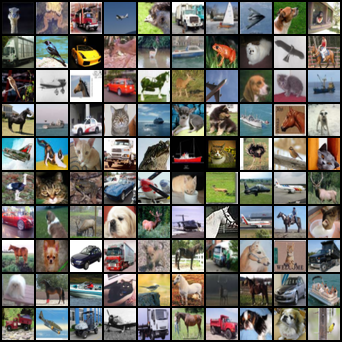

In [153]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

from IPython.display import Image as image_display
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 3, 32, 32)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
image_display(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


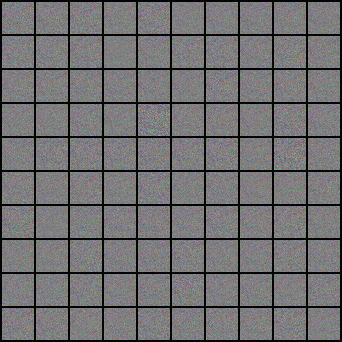

In [154]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 32, 32)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
image_display(os.path.join(sample_dir, 'fake_images-0000.png'))

In [155]:
num_epochs = 10
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 100 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch+1, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [1/10], Step [100/500], d_loss: 2.2235, g_loss: 0.3375, D(x): 0.99, D(G(z)): 0.89
Epoch [1/10], Step [200/500], d_loss: 2.5800, g_loss: 0.3246, D(x): 0.98, D(G(z)): 0.92
Epoch [1/10], Step [300/500], d_loss: 2.8653, g_loss: 0.3226, D(x): 1.00, D(G(z)): 0.94
Epoch [1/10], Step [400/500], d_loss: 3.1836, g_loss: 0.3472, D(x): 0.99, D(G(z)): 0.95
Epoch [1/10], Step [500/500], d_loss: 3.3234, g_loss: 0.3156, D(x): 1.00, D(G(z)): 0.96
Saving fake_images-0001.png
Epoch [2/10], Step [100/500], d_loss: 3.3760, g_loss: 0.3094, D(x): 1.00, D(G(z)): 0.96
Epoch [2/10], Step [200/500], d_loss: 3.5657, g_loss: 0.3157, D(x): 1.00, D(G(z)): 0.97
Epoch [2/10], Step [300/500], d_loss: 4.6594, g_loss: 0.2773, D(x): 0.99, D(G(z)): 0.99
Epoch [2/10], Step [400/500], d_loss: 4.6913, g_loss: 0.2404, D(x): 0.99, D(G(z)): 0.99
Epoch [2/10], Step [500/500], d_loss: 4.5595, g_loss: 0.3742, D(x): 0.99, D(G(z)): 0.98
Saving fake_images-0002.png
Epoch [3/10], Step [100/500], d_loss: 4.5925, g_loss: 0.3700, D(

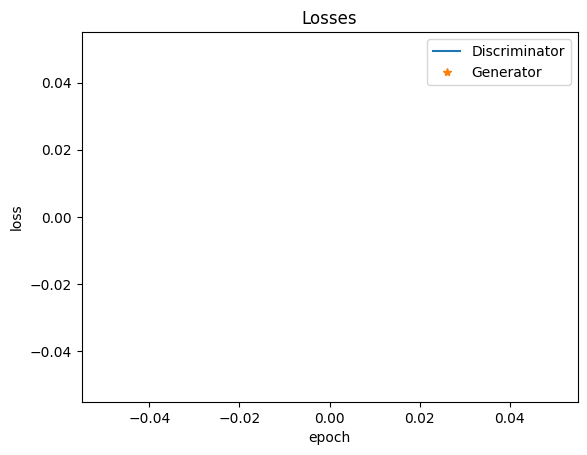

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

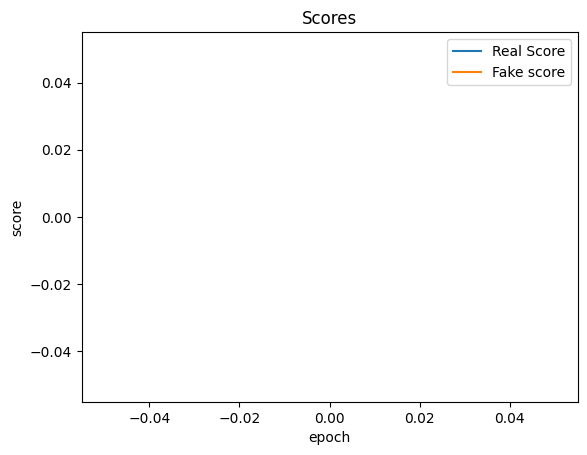

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');